# Do we really need Chocolate Recommendations?

<img src="http://1.bp.blogspot.com/-8dGYKeMKNaU/TvutmCenc-I/AAAAAAAABEo/b2Czf4RlAzw/s1600/Death%2BBy%2BChocolate.JPG" width="400" height="300"/>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Colab Notebooks/
!apt-get -y install openjdk-8-jre-headless
!pip install pyspark

import pyspark
from pyspark import SparkContext as sc
from pyspark import SparkConf

### The master parameter for a SparkContext determines which type and size of cluster to use
### local[K] : run Spark locally with K worker threads 
### local	: run Spark locally with one worker thread 

conf=SparkConf().setAppName("miniProject").setMaster("local[*]")
sc=sc.getOrCreate(conf)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Colab Notebooks
Reading package lists... Done
Building dependency tree       
Reading state information... Done
openjdk-8-jre-headless is already the newest version (8u292-b10-0ubuntu1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


###Collaborative Filtering systems

In this notebook, you will create a recommendation system for **restaurants** using [collaborative filtering](http://en.wikipedia.org/wiki/Collaborative_filtering) (CF). The general structure of a recommendation system is that there are users and there are items. Users express explicit or implicit preferences towards certain items. CF thus relies on users' past behavior.

There are two primary approaches to CF: neighboorhood and latent factor model. The former is concerned with computing the relationships between items or between users. In the latter approach you have a model of hidden factors through which users and items are transformed to the same space. For example, if you are rating movies we may transform items into genre factors, and users into their preference for a particular genre.

Factor models generally lead to more accurate recommenders. One of the reasons for this is the sparsity of the item-user matrix. Most users tend to rate barely one or two items. Latent factor models are more expressive, and fit fewer parameters. However, neighborhood models are more prevalent, as they have an intuitive aspect that appeals to users(if you liked this you will like that) and online(a new preference can be incorporated very quickly).

Most recommenders today combine neighboorhood CF with model based CF, and SVD based matrix factorization approaches.

To see the example of a simple beer recommender, go [here](http://nbviewer.ipython.org/20a18d52c539b87de2af). This notebook is inspired by the one there but we go after food instead, and go deeper into the problem of making recommendations.

### User and Item based approaches

Original approaches to neighborhood based CF used user-user models. By this we mean that rating estimates are made from recorded ratings of like minded users. However, since most users tend to rate very few items, this is usually a losing proposition for explicit-rating based recommenders. Thus, most neighborhood based systems such as Amazon these days rely on item-item approaches. In these methods, a rating is estimated by other ratings made by the user on "similar" or "nearby" items: we have a K-Nearest-Neighbors algorithm, in effect.

###Outline of this Notebook

The outline of this Notebook is as follows:

1. Create a database of item-item similarities. Use this to implement a neighborhood-based CF recommender that can answer simple questions like "give me more restaurants like this one". This part of the notebook assumes that the similaties calculated make good "global recommendations".

2. In the second part, we go one step further and attempt to predict the rating that a user will give an item they have not seen before. This requires that we find the restaurants that *this* user would rate as similar (not just those which are globally similar). 


3. We will scale up our system by creating a recommender on the lines of Q1 and Q2 that works on the entire data set. We will use the map-reduce paradigm to split the computation over multiple machines.

You will start simply, by working on a subset of the restaurant data before generalizing to the entire data set in Problem 4. The complete data set has 150,000 reviews, but we shall start with just about 7000. You will create this  smaller set by taking all the users who had rated more than 60 restaurants, and all the businesses which had greater than 150 reviews from the larger data set. This is not a random set: indeed we use it as it a computationally tractable set that is a bit less sparse than the entire data set.

In [2]:
%matplotlib inline
from collections import defaultdict
import json

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib

### Description of the data set

The data set has been extracted from the Yelp Phoenix restaurants dataset. It is available [here](https://dl.dropboxusercontent.com/u/75194/bigdf.csv).

In [3]:
fulldf=pd.read_csv("bigdf.csv")
print(fulldf.shape)
fulldf.head(2)

(149319, 15)


,user_id,business_id,date,review_id,stars,usefulvotes_review,user_name,categories,biz_name,latitude,longitude,business_avg,business_review_count,user_avg,user_review_count
0,rLtl8ZkDX5vH5nAx9C3q5Q,9yKzy9PApeiPPOUJEtnvkg,2011-01-26 00:00:00,fWKvX83p0-ka4JS3dc6E5A,5,5,Jason,"[Breakfast & Brunch, Restaurants]",Morning Glory Cafe,33.390792,-112.012504,3.87156,109,3.796954,197
1,SBbftLzfYYKItOMFwOTIJg,9yKzy9PApeiPPOUJEtnvkg,2008-05-04 00:00:00,DASdFe-g0BgfN9J2tanStg,5,1,Jennifer,"[Breakfast & Brunch, Restaurants]",Morning Glory Cafe,33.390792,-112.012504,3.87156,109,3.473684,57


In [4]:
import csv 
from io import StringIO
fulldf_spark=sc.textFile("bigdf.csv") \
    .map(lambda line:list(csv.reader(StringIO(line), skipinitialspace=True)))  #line.split(","))

col = fulldf_spark.take(1)[0]
title= dict()

for i,j in enumerate(col[0]):
  title[j]=i
print(title)

fulldf_spark =fulldf_spark.filter(lambda x:x!=col).map(lambda x:x[0])
fulldf_spark.take(2)

{'user_id': 0, 'business_id': 1, 'date': 2, 'review_id': 3, 'stars': 4, 'usefulvotes_review': 5, 'user_name': 6, 'categories': 7, 'biz_name': 8, 'latitude': 9, 'longitude': 10, 'business_avg': 11, 'business_review_count': 12, 'user_avg': 13, 'user_review_count': 14}


[['rLtl8ZkDX5vH5nAx9C3q5Q',
  '9yKzy9PApeiPPOUJEtnvkg',
  '2011-01-26 00:00:00',
  'fWKvX83p0-ka4JS3dc6E5A',
  '5',
  '5',
  'Jason',
  '[Breakfast & Brunch, Restaurants]',
  'Morning Glory Cafe',
  '33.390792',
  '-112.012504',
  '3.871559633027523',
  '109',
  '3.796954314720812',
  '197'],
 ['SBbftLzfYYKItOMFwOTIJg',
  '9yKzy9PApeiPPOUJEtnvkg',
  '2008-05-04 00:00:00',
  'DASdFe-g0BgfN9J2tanStg',
  '5',
  '1',
  'Jennifer',
  '[Breakfast & Brunch, Restaurants]',
  'Morning Glory Cafe',
  '33.390792',
  '-112.012504',
  '3.871559633027523',
  '109',
  '3.473684210526316',
  '57']]

The data frame is a frame of reviews. We have joined in information about users and businesses into this frame so that you have only one frame to work with.

This information is for the reviews themselves:

Here is a description of the data fields in this dataframe, on the business side

And Finally, a set of fields for users

In this data set, every user has only one review for each restaurant. Convince yourself of this. (This answer does not need to be submitted).

###Our Recommender

To motivate our recommendation system, consider the follwing example. Let's pretend we are in Boston for a second. Lets say the average rating of restaurants here by all the users is 3.5. Sandrine's at Harvard square is better than an average restaurant, so it tends to be rated 0.5 stars above the average (over all the users). However, you are a curmudgeon, who tends to rate 0.2 stars below the average. Then a baseline estimate for the recommendation for Sandrine's, for you, is 3.5+0.5-0.2=3.8.

These baseline estimates thus adjust the data by accounting for the systematic tendencies for some users who give higher ratings than others, and for some restaurants to recieve higher ratings than others. We can write the baseline estimate $\hat Y_{um}^{baseline}$ for an unknown rating $Y_{um}$ for user $u$ and restaurant or business $m$ as:

$$ \hat Y_{um}^{baseline} = \hat \mu + \hat \theta_{u0} + \hat \gamma_{m0} $$

where the unknown parameters $\theta_{u0}$ and $\gamma_{m0}$ indicate the deviations, or biases, of user $u$ and item $m$, respectively, from some intercept parameter $\mu$. (The reason for the strange notation with 0s will become clear in Problem 3)

Notice that the $\theta_{u0}$ and $\gamma_{m0}$ are parameters which need to be fit. The simplest thing to start with, and something we will do for Problems 1 and 2 (but not 3), is to replace them by their "mean" estimates from the data. Thus:

$$ \hat Y^{baseline}_{um} = \bar Y + (\bar Y_u - \bar Y) + (\bar Y_m - \bar Y)$$

where $\bar Y_u$ =  `user_avg`, the average of all a user $u$'s ratings and $\bar Y_m$ = `business_avg`, the average of all ratings for a restaurant $m$. $\bar Y$ is the average rating over all reviews.

The final two terms correspond to the user-specific and item-specific bias in ratings, that is, how their ratings tend to systematically diverge from the global average. This is the simplest possible way to predict a rating, based only on information about *this* user and *this* restaurant.

Can we do a better job of predicting the rating $Y_{um}$ user $u$ would give to restaurant $r$? According to the central dogma of CF, we ought to be able to use the responses of *similar* users regarding *similar* restaurants to get a better prediction. 

We can make an estimate of $Y_{um}$ as:

$$ \hat{Y_{um}} = \hat Y_{um}^{baseline}\, + \,\frac{\sum\limits_{j \in S^{k}(m)} s_{mj} ( Y_{uj} - \hat Y_{uj}^{baseline} )}{\sum\limits_{j \in S^{k}(m)} s_{mj} } $$

where $s^{k}(m)$ is the $k$ neighbor items of item $m$ based on some pooling criterion, for example, those items which have been rated by user $u$.

In the next two problems, we will focus on using similar restaurants, or the item neighborhood.
To do this, we compute a *similarity measure* $s_{mj}$ between the $m$th and $j$th items. This similarity might be measured via [cosine similarity](http://en.wikipedia.org/wiki/Cosine_similarity), [pearson co-efficient](http://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient) or using other distance based measures. Here we shall use the Pearson coefficient. This measures the tendency of users to rate items similarly. Since most ratings are unknown, it is computed on the "common user support" (`n_common`), which is the set of common raters of both items. 

In the first problem we shall set $S$ to the global neighborhood of the item, and in the second we shall set it to those items which have been rated by user $u$.

##Q1. Writing a simple "global" recommender

Now we have a way to pool information between similar restaurants to try to predict a user's recommendation. But how do we choose the neighborhood to pool over? We begin with the simplest choice. We calculate the similarity between items using their entire common user support, and rank the nearest neighbors of an item by this similarity. We call this a "global" recommender because it assumes that every user perceives the similarity between restaurants in the same way. Later on, we will implement a more specific recommender that pools information based on which items seem the most similar *to this user*.

The global recommender does have the advantage of dealing with the possible sparsity of the user's rated items, but also the disadvantage of giving one answer for all users, without taking the user's preferences into account. This is a classic case of bias-variance tradeoff.

Lets implement this simpler global recommender first.


### Exploratory Data Analysis

**1.1** Visualize the sparsity of the full data set by plotting two histograms of the review count  grouped by the `user_id` and `business_id` respectively. Are there more users or more businesses? 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


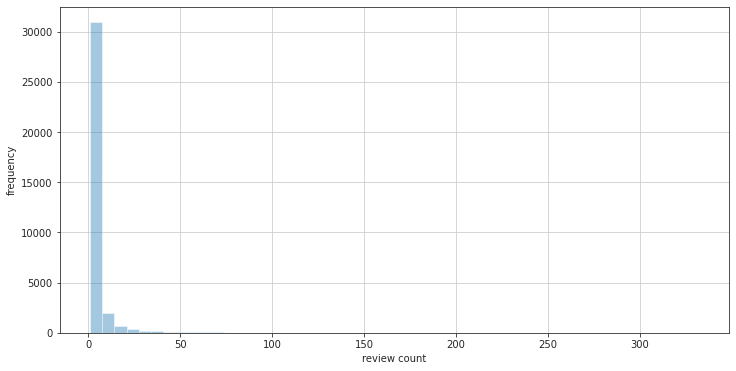

,user_id,count
5504,90a6z--_CUrl84aCzZyPsg,332
23631,fczQCSmaWF78toLEmb0Zsw,302
25403,ikm0UCahtK34LbLCEw4YTw,296
25991,joIzw_aUiNvBTuGoytrH7g,271
2549,3gIfcQq5KxAegwCPXc83cQ,266


In [5]:
import seaborn as sns
review_count_user = fulldf.groupby("user_id")["review_id"].count().reset_index(name='count').sort_values(['count'], ascending=False)   
review_count_user_spark = fulldf_spark.filter(lambda x:x[3]!=np.nan).map(lambda x:(x[0],1)).groupByKey().mapValues(lambda x: sum(x))                     
plt.figure(figsize=[12,6])
sns.set_style("ticks",{'axes.grid' : True})
sns.distplot(review_count_user_spark.map(lambda x:x[1]).collect() ,kde=False)
plt.xlabel("review count")
plt.ylabel("frequency")
plt.show()  
review_count_user.head()

In [6]:
review_count_user_spark.takeOrdered(5,lambda atuple: -atuple[1])

[('90a6z--_CUrl84aCzZyPsg', 332),
 ('fczQCSmaWF78toLEmb0Zsw', 302),
 ('ikm0UCahtK34LbLCEw4YTw', 296),
 ('joIzw_aUiNvBTuGoytrH7g', 271),
 ('3gIfcQq5KxAegwCPXc83cQ', 266)]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


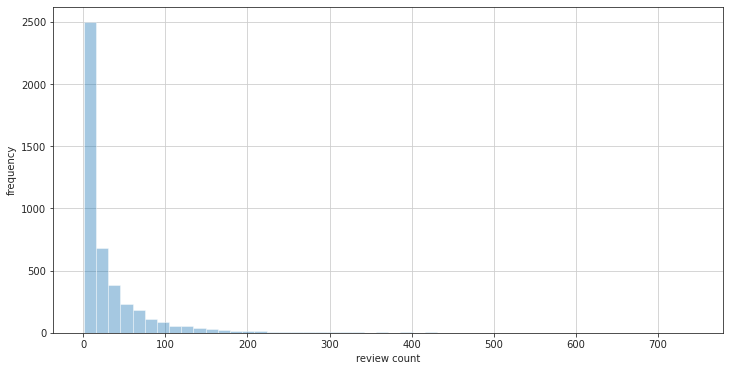

,business_id,count
2360,VVeogjZya58oiTxK7qUjAQ,742
1500,JokKtdXU7zXHcr20Lrk29A,694
3667,ntN85eu27C04nwyPa8IHtw,649
1109,EWMwV5V9BxNs_U6nNVMeqw,598
2310,V1nEpIRmEa1768oj_tuxeQ,553


In [7]:
review_count_business=fulldf.groupby("business_id")["review_id"].count().reset_index(name='count').sort_values(['count'], ascending=False)
review_count_business_spark = fulldf_spark.filter(lambda x:x[3]!=np.nan).map(lambda x:(x[1],1)).groupByKey().mapValues(lambda x: sum(x))
plt.figure(figsize=[12,6])
sns.set_style("ticks",{'axes.grid' : True})
sns.distplot(review_count_business_spark.map(lambda x:x[1]).collect(),kde=False)

plt.xlabel("review count")
plt.ylabel("frequency")
plt.show()                    
review_count_business.head()

In [8]:
review_count_business_spark.takeOrdered(5,lambda atuple: -atuple[1])

[('VVeogjZya58oiTxK7qUjAQ', 742),
 ('JokKtdXU7zXHcr20Lrk29A', 694),
 ('ntN85eu27C04nwyPa8IHtw', 649),
 ('EWMwV5V9BxNs_U6nNVMeqw', 598),
 ('V1nEpIRmEa1768oj_tuxeQ', 553)]

*your answer here*

**1.2** Compute the average rating of reviews in the data set and a histogram of all the ratings in the dataset.

3.7414126802349332
3.741412680234922


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


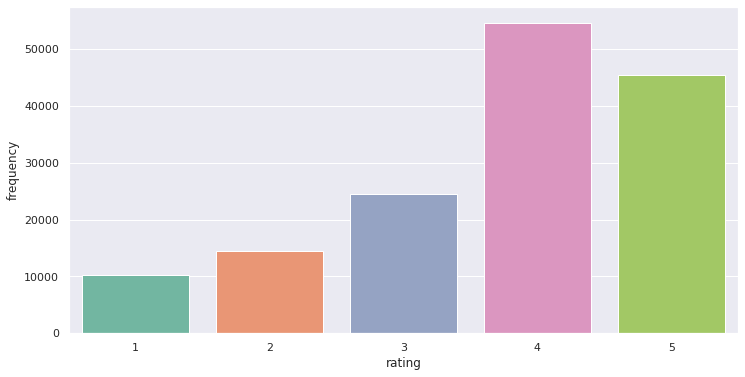

In [9]:
#your code here
print(fulldf["stars"].mean())
print(fulldf_spark.map(lambda x:int(x[title["stars"]])).mean())

plt.figure(figsize=[12,6])
sns.set_theme(style="darkgrid")
sns.countplot(fulldf_spark.map(lambda x:int(x[title["stars"]])).collect(),palette = "Set2")

plt.xlabel("rating")
plt.ylabel("frequency")
plt.show()   

The following function is used to re-compute review counts and averages whenever you subset a reviews data frame. We'll use it soon to construct a smaller, more computationally tractable data frame.

In [10]:
def recompute_frame(ldf):
    """
    takes a dataframe ldf, makes a copy of it, and returns the copy
    with all averages and review counts recomputed
    this is used when a frame is subsetted.
    """
    ldfu=ldf.groupby('user_id')
    ldfb=ldf.groupby('business_id')
    user_avg=ldfu.stars.mean()
    user_review_count=ldfu.review_id.count()
    business_avg=ldfb.stars.mean()
    business_review_count=ldfb.review_id.count()
    nldf=ldf.copy()
    nldf.set_index(['business_id'], inplace=True)
    nldf['business_avg']=business_avg
    nldf['business_review_count']=business_review_count
    nldf.reset_index(inplace=True)
    nldf.set_index(['user_id'], inplace=True)
    nldf['user_avg']=user_avg
    nldf['user_review_count']=user_review_count
    nldf.reset_index(inplace=True)
    return nldf

**1.3** Create a smaller data set in dataframe `smalldf` by looking for those businesses with more than 150 reviews and those users with more than 60 reviews. Include all the columns that were there in the parent dataframe. Since you have created a subset of the data set, use the method provided above to recalculate the averages. Print the number of unique users and items in this data set.  

Note that while this cut makes sure we have prolific users, the cut on businesses restores sparsity  by reducing the number of reviews per user.

In [11]:
#your code here
smalldf=fulldf[(fulldf["user_review_count"]>60) & (fulldf["business_review_count"]>150)]
smalldf=recompute_frame(smalldf)
print(smalldf.shape)
print(len(pd.unique(smalldf["user_id"])))
print(len(pd.unique(smalldf["business_id"])))

(6165, 15)
240
172


In [12]:
smalldf_spark = fulldf_spark.filter(lambda x: int(x[title["user_review_count"]])>60 and int(x[title["business_review_count"]])>150)
user_avg =   smalldf_spark.map(lambda x:(x[title["user_id"]],int(x[title["stars"]]))).groupByKey().mapValues(lambda x:sum(x)/len(list(x))).collectAsMap()
business_avg  = smalldf_spark.map(lambda x:(x[title["business_id"]],int(x[title["stars"]]))).groupByKey().mapValues(lambda x:sum(x)/len(list(x))).collectAsMap()
user_review_count = smalldf_spark.map(lambda x:(x[title["user_id"]],1)).groupByKey().mapValues(lambda x:sum(x)).collectAsMap()
business_review_count = smalldf_spark.map(lambda x:(x[title["business_id"]],1)).groupByKey().mapValues(lambda x:sum(x)).collectAsMap()

def mapping(x):
  output=[]
  for col_name in col[0]:
  
    if col_name not in ["business_avg","'user_avg","business_review_count","user_review_count"]:
      output.append(x[title[col_name]])
    elif col_name=="business_avg":
      output.append(business_avg[x[title["business_id"]]])
    elif col_name=="user_avg":
      output.append(user_avg[x[title["user_id"]]])
    elif col_name=="user_review_count":
      output.append(user_review_count[x[title["user_id"]]])
    else:
      output.append(business_review_count[x[title["business_id"]]])
  return output

smalldf_spark = smalldf_spark.map(lambda x:mapping(x))
smalldf_spark.take(1)

[['rLtl8ZkDX5vH5nAx9C3q5Q',
  'eIxSLxzIlfExI6vgAbn2JA',
  '2011-05-12 00:00:00',
  'z4G1g3VcdfigCUtVDFRL1w',
  '4',
  '5',
  'Jason',
  '[Burgers, Hot Dogs, American (New), Restaurants]',
  'Lobbys Beef Burgers Dogs',
  '33.39476989999999',
  '-111.9088938',
  4.04,
  25,
  '3.796954314720812',
  62]]

How does this compare to the parent data set, in terms of size and sparsity? Once again, plot histograms of the review count grouped by user, and by the review count grouped by business, respectively, and describe the results

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


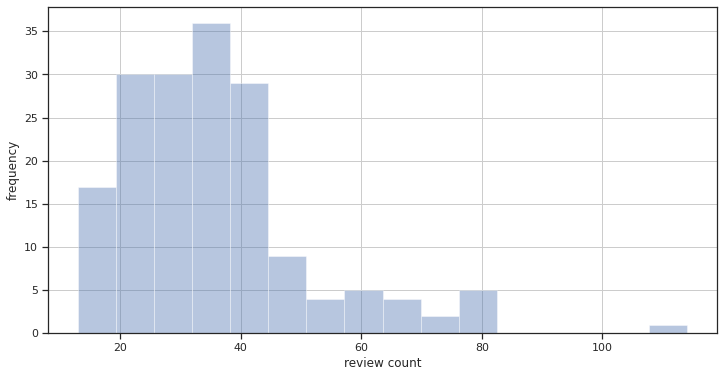

,business_id,count
38,EWMwV5V9BxNs_U6nNVMeqw,114
87,VVeogjZya58oiTxK7qUjAQ,81
145,pwpl-rxwNRQdgqFz_-qMPg,79
3,-sC66z4SO3tR7nFCjfQwuQ,79
85,V1nEpIRmEa1768oj_tuxeQ,78


In [13]:
review_count_business=smalldf.groupby("business_id")["review_id"].count().reset_index(name='count').sort_values(['count'], ascending=False)
review_count_business_spark =smalldf_spark.map(lambda x:(x[title["business_id"]],1)).groupByKey().mapValues(lambda x: sum(x))
plt.figure(figsize=[12,6])
sns.set_style("ticks",{'axes.grid' : True})
sns.distplot(review_count_business_spark.map(lambda x:x[1]).collect(),kde=False)
plt.xlabel("review count")
plt.ylabel("frequency")
plt.show()  

review_count_business.head()

In [14]:
review_count_business_spark.takeOrdered(5,lambda atuple: -atuple[1])

[('EWMwV5V9BxNs_U6nNVMeqw', 114),
 ('VVeogjZya58oiTxK7qUjAQ', 81),
 ('-sC66z4SO3tR7nFCjfQwuQ', 79),
 ('pwpl-rxwNRQdgqFz_-qMPg', 79),
 ('V1nEpIRmEa1768oj_tuxeQ', 78)]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


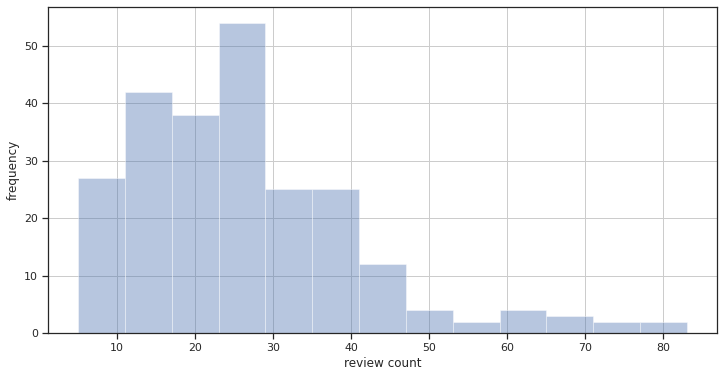

,user_id,count
152,fczQCSmaWF78toLEmb0Zsw,83
22,4ozupHULqGyO42s3zNUzOQ,77
16,3gIfcQq5KxAegwCPXc83cQ,76
72,JgDkCER12uiv4lbpmkZ9VA,73
37,90a6z--_CUrl84aCzZyPsg,69


In [15]:
review_count_user = smalldf.groupby("user_id")["review_id"].count().reset_index(name='count').sort_values(['count'], ascending=False)
review_count_user_spark = smalldf_spark.map(lambda x:(x[title["user_id"]],1)).groupByKey().mapValues(lambda x: sum(x))
plt.figure(figsize=[12,6])
sns.set_style("ticks",{'axes.grid' : True})
sns.distplot(review_count_user_spark.map(lambda x:x[1]).collect(),kde=False)
plt.xlabel("review count")
plt.ylabel("frequency")
plt.show() 
review_count_user.head()

In [16]:
review_count_user_spark.takeOrdered(5,lambda atuple: -atuple[1])

[('fczQCSmaWF78toLEmb0Zsw', 83),
 ('4ozupHULqGyO42s3zNUzOQ', 77),
 ('3gIfcQq5KxAegwCPXc83cQ', 76),
 ('JgDkCER12uiv4lbpmkZ9VA', 73),
 ('90a6z--_CUrl84aCzZyPsg', 69)]

**1.4** Compute histograms of the average user rating in the smaller data set, and the average business rating in the smaller data set. Print the overall mean.

3.867639902676399
3.8676399026763977


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


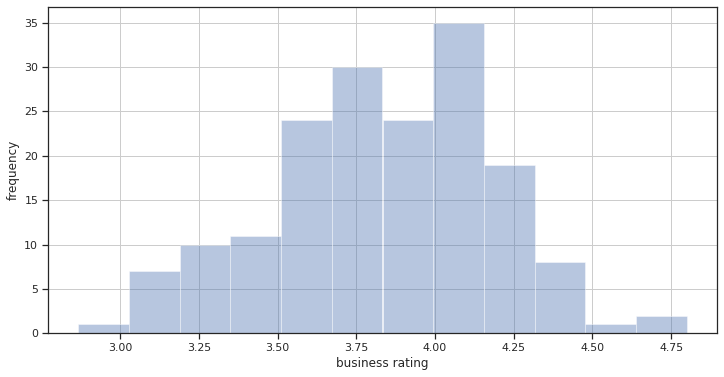

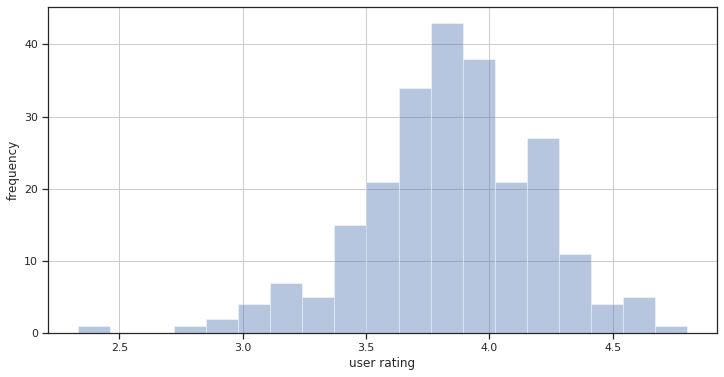

In [17]:
#your code here
print(smalldf["stars"].mean())
print(smalldf_spark.map(lambda x:int(x[title["stars"]])).mean())
rating_business=smalldf.groupby("business_id")["stars"].mean().reset_index(name='mean') \
                             .sort_values(['mean'], ascending=False)
plt.figure(figsize=[12,6])
sns.set_style("ticks",{'axes.grid' : True})
sns.distplot(rating_business['mean'],kde=False)
plt.xlabel("business rating")
plt.ylabel("frequency")
plt.show()   

rating_user=smalldf.groupby("user_id")["stars"].mean().reset_index(name='mean') \
                             .sort_values(['mean'], ascending=False)
plt.figure(figsize=[12,6])
sns.set_style("ticks",{'axes.grid' : True})
sns.distplot(rating_user['mean'],kde=False)
plt.xlabel("user rating")
plt.ylabel("frequency")
plt.show()    

###Common Support

Lets now make a histogram of the common user support (the number of common reviewers) of each pair of restaurants on the smaller set, and print the mean. Pay attention to the code, as you will use parts of it later. (This code takes a bit of time to run, so be patient).

The common support is an important concept, as for each pair of restaurants, its the number of people who reviewed both. It will be used to modify similarity between restaurants. If the common support is low, the similarity is less believable.

172
Mean support is: 6.846797225622195


(array([7.020e+03, 4.987e+03, 1.794e+03, 5.900e+02, 1.950e+02, 7.600e+01,
        2.200e+01, 1.000e+01, 1.000e+01, 2.000e+00]),
 array([ 0. ,  5.1, 10.2, 15.3, 20.4, 25.5, 30.6, 35.7, 40.8, 45.9, 51. ]),
 <a list of 10 Patch objects>)

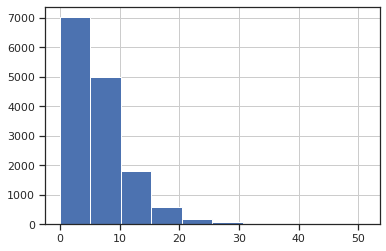

In [18]:
# restaurants=smalldf.business_id.unique()

restaurants = list(set(smalldf_spark.map(lambda x:x[title["business_id"]]).collect()))
print(len(restaurants))
supports=[]
for i,rest1 in enumerate(restaurants):
    #rest1_reviewers =  smalldf_spark.filter(lambda x:x[title["business_id"]]==rest1).map(lambda x:x[title["user_id"]]).distinct().collect()
    rest1_reviewers = smalldf[smalldf.business_id==rest1].user_id.unique() 
    for j,rest2 in enumerate(restaurants):
        if  i < j:
                
            ###smalldf[smalldf.business_id==rest1].user_id.unique()
            #rest2_reviewers =  smalldf_spark.filter(lambda x:x[title["business_id"]]==rest2).map(lambda x:x[title["user_id"]]).distinct().collect()         
            rest2_reviewers = smalldf[smalldf.business_id==rest2].user_id.unique()
            common_reviewers = set(rest1_reviewers).intersection(rest2_reviewers)
            supports.append(len(common_reviewers))
print ("Mean support is:",np.mean(supports))
plt.hist(supports)

As you can see, even though we chose a subset of the dataframe in which every restaurant had 150 reviews and every user had atleast made 60, the common support of most pairs of restaurants is really low, indeed less than 10!.

### Calculating Similarity

Users rate restaurants on a scale of 1-5. Even though this rating is integer valued, for the purposes of this assignment we shall treat it as a real number.

Even though each reviewer uses the same 5-star scale when rating restaurants, comparing two users by comparing their raw user ratings can be problematic. Consider a user whose average rating is 2. This is a curmudgeonly user. Consider another whose average rating is 4. This is a rather enthusiastic one. How should we compare a 3 rating by the curmudgeonly one to a 5 rating of the enthusiastic one?

It is for this purpose that we must subtract the average rating of the user from the actual rating of the restaurants in computing the similarity of two restaurants. This makes the above ratings by the two users comparable. We do this in the function `pearson_sim` defined below.

If there is no common support (`n_common=0`), we have no basis for making a similarity estimate, and so we set the similarity to 0. In the case that the individual restaurant rating variance is 0, such as in the case where there is only one common reviewer (`n_common=1`), we return the `NaN` that the scipy `pearsonr` returns. We will deal with it soon,

In [19]:
from scipy.stats.stats import pearsonr
def pearson_sim(rest1_reviews, rest2_reviews, n_common):
    """
    Given a subframe of restaurant 1 reviews and a subframe of restaurant 2 reviews,
    where the reviewers are those who have reviewed both restaurants, return 
    the pearson correlation coefficient between the user average subtracted ratings.
    The case for zero common reviewers is handled separately. Its
    ok to return a NaN if any of the individual variances are 0.
    """
    if n_common<=1:
        rho=0.
    else:
        diff1=rest1_reviews['stars']-rest1_reviews['user_avg']
        diff2=rest2_reviews['stars']-rest2_reviews['user_avg']
        rho=pearsonr(diff1, diff2)[0]
    return rho

The function `get_restaurant_reviews` defined below takes a restaurant `business_id` and a set of users, and returns the reviews of that restaurant by those users. You will use this function in calculating a similarity function, in **1.5**.

In [20]:
def get_restaurant_reviews(restaurant_id, df, set_of_users):
    """
    given a resturant id and a set of reviewers, return the sub-dataframe of their
    reviews.
    """
    mask = (df.user_id.isin(set_of_users)) & (df.business_id==restaurant_id)
    reviews = df[mask]
    reviews = reviews[reviews.user_id.duplicated()==False]
    return reviews

**1.5** Write a function `calculate_similarity` that operates between two restaurants and calculates a similarity for them, taking a dataframe and a similarity function `similarity_func`. An example of the `similarity_func` is the `pearson_sim` we defined above. `calculate_similarity` operates as follows: 

1. For each of the two restaurants, get the set of reviewers who have reviewed the restaurant and compute the intersection of these two sets. Also compute the number of common reviewers `n_common`.

2. Use the function `get_restaurant_reviews` defined below to get the reviews for each restaurant as made by these common reviewers. Notice that `get_restaurant_reviews` returns a sub data frame of reviews.

3. Calculate the similarity using `similarity_func` which takes the two reviews dataframes from part 2 and the number of common reviewers `n_common` as arguments

4. Return the similarity and `n_common` in a tuple `(sim, n_common)`. If the similarity is a `NaN`, set the similarity to 0.


In [21]:
"""
Function
--------
calculate_similarity

Parameters
----------
rest1 : string
    The id of restaurant 1
rest2 : string
    The id of restaurant 2
df : DataFrame
  A dataframe of reviews, such as the smalldf above
similarity_func : func
  A function like pearson_sim above which takes two dataframes of individual
  restaurant reviews made by a common set of reviewers, and the number of
  common reviews. This function returns the similarity of the two restaurants
  based on the common reviews.
  
Returns
--------
A tuple
  The first element of the tuple is the similarity and the second the
  common support n_common. If the similarity is a NaN, set it to 0
"""
#your code here
def calculate_similarity(rest1,rest2,df,similarity_func):
   a1 = df[df.business_id==rest1].user_id.unique()
   a2 = df[df.business_id==rest2].user_id.unique()
   common_user = set(a1).intersection(a2) 
   n_common =len(common_user)

   d1= get_restaurant_reviews(rest1, df, common_user)
   d2= get_restaurant_reviews(rest2, df, common_user)

   sim =similarity_func(d1,d2, n_common)


   if sim==np.nan:
     return (0,n_common)
   else:
     return (sim,n_common)


### Making a database of similarities

We now move to calculating a global database of pairwise restaurant similarities.
We provide you here with a function to make a database of the similarities for each pair of restaurants in the database. The class `Database` is initialized in its constructor by taking as arguments a dataframe of reviews. The method `populate_by calculating` iterates over every possible pair of business_id's in the dataframe and populates the database with similarities and common supports. It takes as arguments a function the similarity function `similarity_func` like `pearson_sim` (`calculate_similarity` then uses this to calculate the similarity). The `get` method on the database can be used to retrieve the similarity for two business ids.

(See Thu Oct 17th's class video for information about classes)

In [22]:
class Database:
    "A class representing a database of similaries and common supports"
    
    def __init__(self, df):
        "the constructor, takes a reviews dataframe like smalldf as its argument"
        database={}
        self.df=df
        self.uniquebizids={v:k for (k,v) in enumerate(df.business_id.unique())}
        keys=self.uniquebizids.keys()
        l_keys=len(keys)
        self.database_sim=np.zeros([l_keys,l_keys])
        self.database_sup=np.zeros([l_keys, l_keys], dtype=np.int)
        
    def populate_by_calculating(self, similarity_func):
        """
        a populator for every pair of businesses in df. takes similarity_func like
        pearson_sim as argument
        """
        items=self.uniquebizids.items()
        for b1, i1 in items:
            for b2, i2 in items:
                if i1 < i2:
                    sim, nsup=calculate_similarity(b1, b2, self.df, similarity_func)
                    self.database_sim[i1][i2]=sim
                    self.database_sim[i2][i1]=sim
                    self.database_sup[i1][i2]=nsup
                    self.database_sup[i2][i1]=nsup
                elif i1==i2:
                    nsup=self.df[self.df.business_id==b1].user_id.count()
                    self.database_sim[i1][i1]=1.
                    self.database_sup[i1][i1]=nsup
                    

    def get(self, b1, b2):
        "returns a tuple of similarity,common_support given two business ids"
        sim=self.database_sim[self.uniquebizids[b1]][self.uniquebizids[b2]]
        nsup=self.database_sup[self.uniquebizids[b1]][self.uniquebizids[b2]]
        return (sim, nsup)

Lets run `make_database` and store the result in the global variable `db`. Lets print out an example entry. Running this function will take a bit of time.

In [23]:
db=Database(smalldf)
db.populate_by_calculating(pearson_sim)

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [24]:
db.get("z3yFuLVrmH-3RJruPEMYKw", "zruUQvFySeXyEd7_rQixBg")

(0.3990455452573456, 7)

### K-Nearest restaurants (in similarity)

We are now going to find the k-nearest restaurants to a given restaurant based on the database of similarities that we calculated. But we have a problem.

Consider the two cases where there is just one common reviewer, and where there are 40. In the former case, we might get a artificially high similarity based on the tastes of just this user, and thus we must reduce its importance in the nearest-neighbor calculation. In the latter case, we would get a much more unbiased estimator of the similarity of the two restaurants.

To control the effect of small common supports, we can **shrink** our pearson co-efficients. We shall do this by using the "regularization" parameter `reg`:

$$s_{mj} = \frac{N_{common}\, \rho_{mj}}{N_{common}+reg} $$

where $N_{common}$ (`n_common`) is the common reviewer support and $\rho_{ij}$ is the pearson co-relation coefficient.

Recall the notions of regularization introduced in class. We want to reduce the variance in our estimates, so we pull our estimates in toward a conservative point in a way that strongly corrals in estimates when there is very little data, but allows the data to speak when there is a lot. This can be shown as equivalent to adding in a `reg` amount of bayesian prior, as Joe has alluded to in class. 

A good value of the regularizer is intuitively one that doesn't affect the similarity when the common support is high ~10, but has a large effect when the support is small. In this case, values of 2-4 are good. Usually, the value of `reg` is determined using cross-validation, but for the sake of simplicity we will generally set it to 3.

We define a function `shrunk_sim` which takes the `sim` and `n_common` obtained from the database, and shrinks the similarity down using the regularizer `reg`.

In [25]:
def shrunk_sim(sim, n_common, reg=3.):
    "takes a similarity and shrinks it down by using the regularizer"
    ssim=(n_common*sim)/(n_common+reg)
    return ssim

**1.6** Now we can move to writing a `knearest` function, which finds the `k` nearest neighbors of a given restaurant based on the shrunk similarities we calculate. Note that as defined here, the nearest neighbors are global over the entire set of restaurants, as opposed to being restricted to the restaurants a user has reviewed(we shall do that in the next problem). Thus, this is an expensive function!

Write a `knearest` that returns a *k-length sorted list* of 3-tuples each corresponding to a restaurant. The tuple structure is `(business_id, shrunken similarity score, common support)` where the similarity score and common support are with respect to the restaurant whose neighbors we are finding, and the `business_id` is the id of the "nearby" restaurant found. The nearby restaurants are found from a supplied numpy array of restaurants `set_of_restaurants`. The spec for the function is given below. HINT: use `itemgetter` from the `operator` module to do the sorting.

In [26]:
"""
Function
--------
knearest

Parameters
----------
restaurant_id : string
    The id of the restaurant whose nearest neighbors we want
set_of_restaurants : array
    The set of restaurants from which we want to find the nearest neighbors
dbase : instance of Database class.
    A database of similarities, on which the get method can be used to get the similarity
  of two businessed. e.g. dbase.get(rid1,rid2)
k : int
    the number of nearest neighbors desired, default 7
reg: float
    the regularization.
    
  
Returns
--------
A sorted list
    of the top k similar restaurants. The list is a list of tuples
    (business_id, shrunken similarity, common support).
"""
#your code here

def knearest(restaurant_id,set_of_restaurants,dbase,reg=3.,k=7):
  sorting=[]
  for res in list(set_of_restaurants):
    if restaurant_id!=res:
     sim,n_common= dbase.get(restaurant_id,res)
     sim= shrunk_sim(sim, n_common, reg)
     sorting.append((res,sim,n_common))
  sorted_by_second = sorted(sorting, key=lambda tup: -tup[1])
  return sorted_by_second[0:k]

### Ok it's time to recommend!

Lets choose the two very different businesses in the dataframe

In [27]:
testbizid="eIxSLxzIlfExI6vgAbn2JA"
testbizid2="L-uPZxooP_ziXCtRrWi8Pw"

We provide functions to look up a business name given a business id, and a username given a user id.

In [28]:
def biznamefromid(df, theid):
    return df['biz_name'][df['business_id']==theid].values[0]
def usernamefromid(df, theid):
    return df['user_name'][df['user_id']==theid].values[0]

In [29]:
print (testbizid, biznamefromid(smalldf,testbizid))
print (testbizid2, biznamefromid(smalldf, testbizid2))

eIxSLxzIlfExI6vgAbn2JA Lobbys Beef Burgers Dogs
L-uPZxooP_ziXCtRrWi8Pw Café Monarch


####Get top matches

Its now time to answer the question: "if you liked this, you might also like these". We use our `testbizid` and `testbizid2` to compute the `k=7` nearest neighbors with a regularization of `3.` . We print these top 7 matches names, along with their similarity coefficient and common support.

In [30]:
tops=knearest(testbizid, smalldf.business_id.unique(), db, k=7, reg=3.)
print ("For ",biznamefromid(smalldf, testbizid), ", top matches are:")
for i, (biz_id, sim, nc) in enumerate(tops):
    
    print (i,biznamefromid(smalldf,biz_id), "| Sim", sim, "| Support",nc)

For  Lobbys Beef Burgers Dogs , top matches are:
0 La Condesa Gourmet Taco Shop | Sim 0.598714448433877 | Support 6
1 Citizen Public House | Sim 0.5714285714285714 | Support 4
2 FnB | Sim 0.5271298909432433 | Support 5
3 Defalco's Italian Grocery | Sim 0.5194565556584358 | Support 6
4 Republic Ramen + Noodles | Sim 0.5191401469365293 | Support 5
5 unPhogettable | Sim 0.5 | Support 3
6 Haus Murphy's | Sim 0.4676372353077225 | Support 3


In [31]:
tops2=knearest(testbizid2, smalldf.business_id.unique(), db, k=7, reg=3.)
print ("For ",biznamefromid(smalldf, testbizid2), ", top matches are:")
for i, (biz_id, sim, nc) in enumerate(tops2):
    print (i,biznamefromid(smalldf,biz_id), "| Sim", sim, "| Support",nc)

For  Café Monarch , top matches are:
0 Postino Arcadia | Sim 0.625 | Support 5
1 The Main Ingredient Ale House And Café | Sim 0.5714285714285714 | Support 4
2 Brio Tuscan Grille | Sim 0.5714285714285714 | Support 4
3 Harlow's Cafe | Sim 0.5 | Support 3
4 The Fry Bread House | Sim 0.5 | Support 3
5 Cien Agaves Tacos & Tequila | Sim 0.5 | Support 3
6 Kazimierz World Wine Bar | Sim 0.49999999999999994 | Support 3


We can see that these two restaurants are in somewhat different orbits :-).

Lets now turn our attention to another question: what are the top recommendations for a user? To answer this we must find the user's top rated restaurants, find the nearest neighbors of these restaurants, merge these lists while removing the duplicates and the ones that the user has already rated, and sort by the restaurant's average rating. We provide the code to get the user's top choices in a subset data frame.

In [32]:
def get_user_top_choices(user_id, df, numchoices=5):
    "get the sorted top 5 restaurants for a user by the star rating the user gave them"
    udf=df[df.user_id==user_id][['business_id','stars']].sort_values(['stars'], ascending=False).head(numchoices)
    return udf
testuserid="7cR92zkDv4W3kqzii6axvg"
print ("For user", usernamefromid(smalldf,testuserid), "top choices are:" )
bizs=get_user_top_choices(testuserid, smalldf)['business_id'].values
[biznamefromid(smalldf, biz_id) for biz_id in bizs]

For user Vern top choices are:


['Tee Pee Mexican Food',
 'Local Breeze',
 "Carly's Bistro",
 'District American Kitchen and Wine Bar',
 'Sonora Mesquite Grill']

#### Get top recommendations for user.

**1.7** Its your job now to write a function `get_top_recos_for_user` which takes as arguments a `userid`, the `n` top choices for the user, the dataframe, `k`, and a regularizer, and returns the top recommendations obtained from combining the restaurants that are neighbors of each of the `n` choices, in the way described in the previous paragraph. This returned list is a list of tuples `(restaurant_id, business_avg)` sorted by `business_avg` where `business_avg` is the average rating of the restaurant over the dataframe.

In [33]:
"""
Function
--------
get_top_recos_for_user

Parameters
----------
userid : string
    The id of the user for whom we want the top recommendations
df : Dataframe
    The dataframe of restaurant reviews such as smalldf
dbase : instance of Database class.
    A database of similarities, on which the get method can be used to get the similarity
  of two businesses. e.g. dbase.get(rid1,rid2)
n: int
    the n top choices of the user by star rating
k : int
    the number of nearest neighbors desired, default 8
reg: float
    the regularization.
    
  
Returns
--------
A sorted list
    of the top recommendations. The list is a list of tuples
    (business_id, business_avg). You are combining the k-nearest recommendations 
    for each of the user's n top choices, removing duplicates and the ones the user
    has already rated.
"""
#your code here
def get_top_recos_for_user(userid,df,dbase,n,k,reg):
   res = get_user_top_choices(userid, df, numchoices=n)['business_id'].values
   set_of_restaurants = df.business_id.unique()
   rated = df[df.user_id==userid].business_id.unique()
   unrated=[x for x in set_of_restaurants if x not in rated]
   output =[]
   for i in res:
      ans= knearest(i,unrated,dbase,reg,k)
      output.extend(ans)
   output =[(x[0],df[df.business_id==x[0]].business_avg.iloc[0]) for x in output]
   return sorted(output , key=lambda tup: -tup[1])[:n]


Lets print the top recommendations for `testuserid`, with a regularization of 3.

In [34]:
print ("For user", usernamefromid(smalldf,testuserid), "the top recommendations are:")
toprecos=get_top_recos_for_user(testuserid, smalldf, db, n=5, k=7, reg=3.)
#print(toprecos)
#print(smalldf[(smalldf.user_id=="7cR92zkDv4W3kqzii6axvg") & (smalldf.business_id=="z3yFuLVrmH-3RJruPEMYKw")])
for biz_id, biz_avg in toprecos:
    print(biznamefromid(smalldf,biz_id), "| Average Rating |", biz_avg)

For user Vern the top recommendations are:
Rokerij | Average Rating | 4.379310344827586
Wildfish Seafood Grille | Average Rating | 4.294117647058823
Defalco's Italian Grocery | Average Rating | 4.232558139534884
Cornish Pasty Company | Average Rating | 4.206896551724138
Pappadeaux Seafood Kitchen | Average Rating | 4.185185185185185


## Problem 2: A user based recommender with predicted ratings

This is all very nice. We can provide ratings based on global similarities to a restaurant. However, in many cases this is not enough.

For example, it is hard to judge if the above recommendations are any good. In the usual testing paradigm, say that we break the dataframe into train and test. Based on the training set, I am recommended restaurant B. Now, I have rated B, but that information is in the testing set. I have no way of comparing the rating I give B in the testing set, to the similarity computed from the training set that was used to make the recomendation. The best I could do is to compare the average rating of restaurant B in the training set to my rating of restaurant B in the test set. 

In this section, we shift our focus to more fine-grained predictions about each user, and try to predict what _rating_ a user would give to a restaurant they have never tried before. To do this, we will try to personalize the information we use even further, and only pool information from restaurants that the user has rated.

This allows us to return to the original problem of prediction $Y_{um}$ for a restaurant $m$ that user $u$ has never rated before. Using our newly computed similarity metrics, we can modify our original baseline estimate by pulling in information from the user's neighborhood of the restaurant $m$, and predict $Y_{um}$ as:

$$ \hat{Y_{um}} = \hat Y^{baseline}_{um}\, + \,\frac{\sum\limits_{j \in S^{k}(m;u)} s_{mj} ( Y_{uj} - \hat Y^{baseline}_{uj} )}{\sum\limits_{j \in S^{k}(m;u)} s_{mj} } $$

where $s^{k}(m;u)$ is the $k$ neighbor items of item $m$ which have been rated by user $u$.

Now, this is not a particularly good assumption, especially in the situation where a restaurant is new (new item problem) or a user is new (cold start problem), or in the case when there are very few reviewers of a restaurant, or very few reviews by a user respectively. However, one must start somewhere!

Notice that in adding in the similarity term, we subtract the baseline estimate from the observed rating of the user's neighbor items.

###Defining the predicted rating

**2.1** Write a function `knearest_amongst_userrated`, analogous to the `knearest` function we defined above, to find the nearest `k` neighbors to a given restaurant from the **restaurants that the user has already rated**. This function will take as arguments the `restaurant_id`, the `user_id`, the dataframe of reviews, the database, the `k`, and the regularizer `reg`. Just like before, return a *k-length sorted list* of 3-tuples each corresponding to a restaurant.  HINT: use the `knearest` function you defined earlier

In [44]:
"""
Function
--------
knearest_amongst_userrated

Parameters
----------
restaurant_id : string
    The id of the restaurant whose nearest neighbors we want
user_id : string
    The id of the user, in whose reviewed restaurants we want to find the neighbors
df: Dataframe
    The dataframe of reviews such as smalldf
dbase : instance of Database class.
    A database of similarities, on which the get method can be used to get the similarity
  of two businessed. e.g. dbase.get(rid1,rid2)
k : int
    the number of nearest neighbors desired, default 7
reg: float
    the regularization.
    
  
Returns
--------
A sorted list
    of the top k similar restaurants. The list is a list of tuples
    (business_id, shrunken similarity, common support).
"""
#your code here
def knearest_amongst_userrated(restaurant_id,user_id,df,dbase,k,reg):
   set_of_restaurants = df.business_id.unique()
   rated = df[df.user_id==user_id].business_id.unique()
   
   return knearest(restaurant_id,rated,dbase,reg,k)


**2.2** Now write a function that returns the predicted rating for a user and an item using the formula at the beginning of this problem. Include code to deal with the possibility that the sum of scores that goes in the denominator is 0: return a predicted rating of the baseline portion of the formula in that case. This function `rating` takes as arguments the dataframe, the database, the wanted `restaurant_id` and `user_id`, and `k` as well as the regularizer.

In [45]:
"""
Function
--------
rating

Parameters
----------
df: Dataframe
    The dataframe of reviews such as smalldf
dbase : instance of Database class.
    A database of similarities, on which the get method can be used to get the similarity
  of two businessed. e.g. dbase.get(rid1,rid2)
restaurant_id : string
    The id of the restaurant whose nearest neighbors we want
user_id : string
    The id of the user, in whose reviewed restaurants we want to find the neighbors
k : int
    the number of nearest neighbors desired, default 7
reg: float
    the regularization.
    
  
Returns
--------
A float
    which is the impued rating that we predict that user_id will make for restaurant_id
"""
#your code here

def rating(df,dbase,restaurant_id,user_id,k,reg):
  avg = df["stars"].mean()
  user_avg =df[df.user_id==user_id]["stars"].mean()
  business_avg = df[df.business_id=="restaurant_id"]["stars"].mean()

  est = avg+(user_avg-avg)+(business_avg-avg)
  sim = knearest_amongst_userrated(restaurant_id,user_id,df,dbase,k,reg)
  
  score=0
  norm=0

  for i in sim:
    actual =df[(df.user_id==user_id)&(df.business_id==i[0])]["stars"].iloc[0]
    est_ = df[df.business_id==i[0]]["stars"].mean()
    score+= (actual-est_)*i[1]
    norm+=i[1]
 
  est+= score/norm
  return est


For the top-recommendations in the variable `toprecos` from the previous section, we compute the predicted rating and compare it with the average rating over all users available inside the tuples that make up `toprecos`. We use a `k` of 7 and regularization 3. For comparision we also print this users' average rating. Do you notice anything interesting about how the order has changed from when we did this with the global similarities? (for you to think, not to answer)

In [46]:
print ("User Average", smalldf[smalldf.user_id==testuserid].stars.mean(),"for",usernamefromid(smalldf,testuserid))
print ("Predicted ratings for top choices calculated earlier:")
for biz_id,biz_avg in toprecos:
    print (biznamefromid(smalldf, biz_id),"|",rating(smalldf, db, biz_id, testuserid, k=7, reg=3.),"|","Average",biz_avg)

User Average 3.5652173913043477 for Vern
Predicted ratings for top choices calculated earlier:
Rokerij | nan | Average 4.379310344827586
Wildfish Seafood Grille | nan | Average 4.294117647058823
Defalco's Italian Grocery | nan | Average 4.232558139534884
Cornish Pasty Company | nan | Average 4.206896551724138
Pappadeaux Seafood Kitchen | nan | Average 4.185185185185185


###Testing the ratings

Let us compare the predicted ratings with a user's ratings. Note that we are doing this on the same set that we constructed the predictions with, so this is not a validation of the procedure, but simply a check of the procedure's fit. We first write a helper function to return the user score for a restaurant, and the restaurant's average score over all users.

In [47]:
def get_other_ratings(restaurant_id, user_id, df):
    "get a user's rating for a restaurant and the restaurant's average rating"
    choice=df[(df.business_id==restaurant_id) & (df.user_id==user_id)]
    users_score=choice.stars.values[0]
    average_score=choice.business_avg.values[0]
    return users_score, average_score

For the user `testuserid`, we loop over the variable `bizs` (which is a set of restaurants the user has rated) and print the predicted rating, and the actual rating and restaurant average rating obtained using the function above. We again use `k=7` and a regularization of 3.

In [49]:
print ("for user",usernamefromid(smalldf,testuserid), 'avg', smalldf[smalldf.user_id==testuserid].stars.mean())
for biz_id in bizs:
    print ("----------------------------------")
    print (biznamefromid(smalldf, biz_id))
    print ("Predicted Rating:",rating(smalldf, db, biz_id, testuserid, k=7, reg=3.))
    u,a=get_other_ratings(biz_id, testuserid, smalldf)
    print ("Actual User Rating:",u,"Avg Rating",a)

for user Vern avg 3.5652173913043477
----------------------------------
Tee Pee Mexican Food
Predicted Rating: nan
Actual User Rating: 5 Avg Rating 3.0434782608695654
----------------------------------
Local Breeze
Predicted Rating: nan
Actual User Rating: 5 Avg Rating 4.0
----------------------------------
Carly's Bistro
Predicted Rating: nan
Actual User Rating: 5 Avg Rating 3.5
----------------------------------
District American Kitchen and Wine Bar
Predicted Rating: nan
Actual User Rating: 4 Avg Rating 3.5526315789473686
----------------------------------
Sonora Mesquite Grill
Predicted Rating: nan
Actual User Rating: 4 Avg Rating 4.384615384615385
